In [46]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

e_inv = -1060000
w_inv = 900000
n_inv = -1900000
s_inv = 60000
inv_reg = [e_inv, w_inv, n_inv, s_inv]

inv_height = 80
inv_width = inv_height*(w_inv-e_inv)/(s_inv-n_inv)
inv_ratio = (s_inv-n_inv)/(inv_height/1000)
inv_proj = f"x1:{inv_ratio}"

buffer = 400e3
e_fig = e_inv+buffer
w_fig = w_inv-buffer
n_fig = n_inv+buffer
s_fig = s_inv-buffer
fig_reg = [e_fig, w_fig, n_fig, s_fig]

fig_height = 80
fig_width = fig_height*(w_fig-e_fig)/(s_fig-n_fig)
fig_ratio = (s_fig-n_fig)/(fig_height/1000)
fig_proj = f"x1:{fig_ratio}"

In [47]:
inv_region="-1060000/900000/-1900000/60000"
!gmt grdsample -R{inv_region} -rg -I40e3  ../gravity_data/ant4d_gravity.nc -G../inversion_layers/gravity_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc -G../inversion_layers/BedMachine_surface_filled_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc -G../inversion_layers/BedMachine_icebase_filled_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/bedmachine/BedMachine_bed_5k.nc -G../inversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/RE_basement_BedMachinebed_filled.nc -G../inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/ANTASed_mag_basement_filled.nc -G../inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


In [48]:
# surface = xr.load_dataarray("../inversion_layers/BedMachine_surface_5k_filled.nc")
# icebase = xr.load_dataarray("../inversion_layers/BedMachine_icebase_5k_filled.nc")
# bed = xr.load_dataarray("../inversion_layers/BedMachine_bed_5k.nc")
# basement = xr.load_dataarray("../inversion_layers/ROSETTA_basement_BedMachine_bed.nc", drop_variables='polar_stereographic')

grav = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc')
surface = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc')
icebase = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc')
bed = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc')
basement = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc')

df_grav=grav.to_dataframe().reset_index()
df_grav.rename(columns={'z':'Gobs'}, inplace=True)
# df_grav['z']=750
df_grav['z']=surface.to_dataframe().reset_index().z+750
df_grav

,x,y,Gobs,z
0,-1060000.0,-1900000.0,-23.000000,750.000000
1,-1060000.0,-1860000.0,-25.100000,750.000000
2,-1060000.0,-1820000.0,-22.240000,750.000000
3,-1060000.0,-1780000.0,-5.470001,750.000000
4,-1060000.0,-1740000.0,-50.959999,750.000000
...,...,...,...,...
2495,900000.0,-100000.0,9.390000,4303.792969
2496,900000.0,-60000.0,26.189999,4347.184570
2497,900000.0,-20000.0,20.319996,4393.708008
2498,900000.0,20000.0,47.159996,4451.599609


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


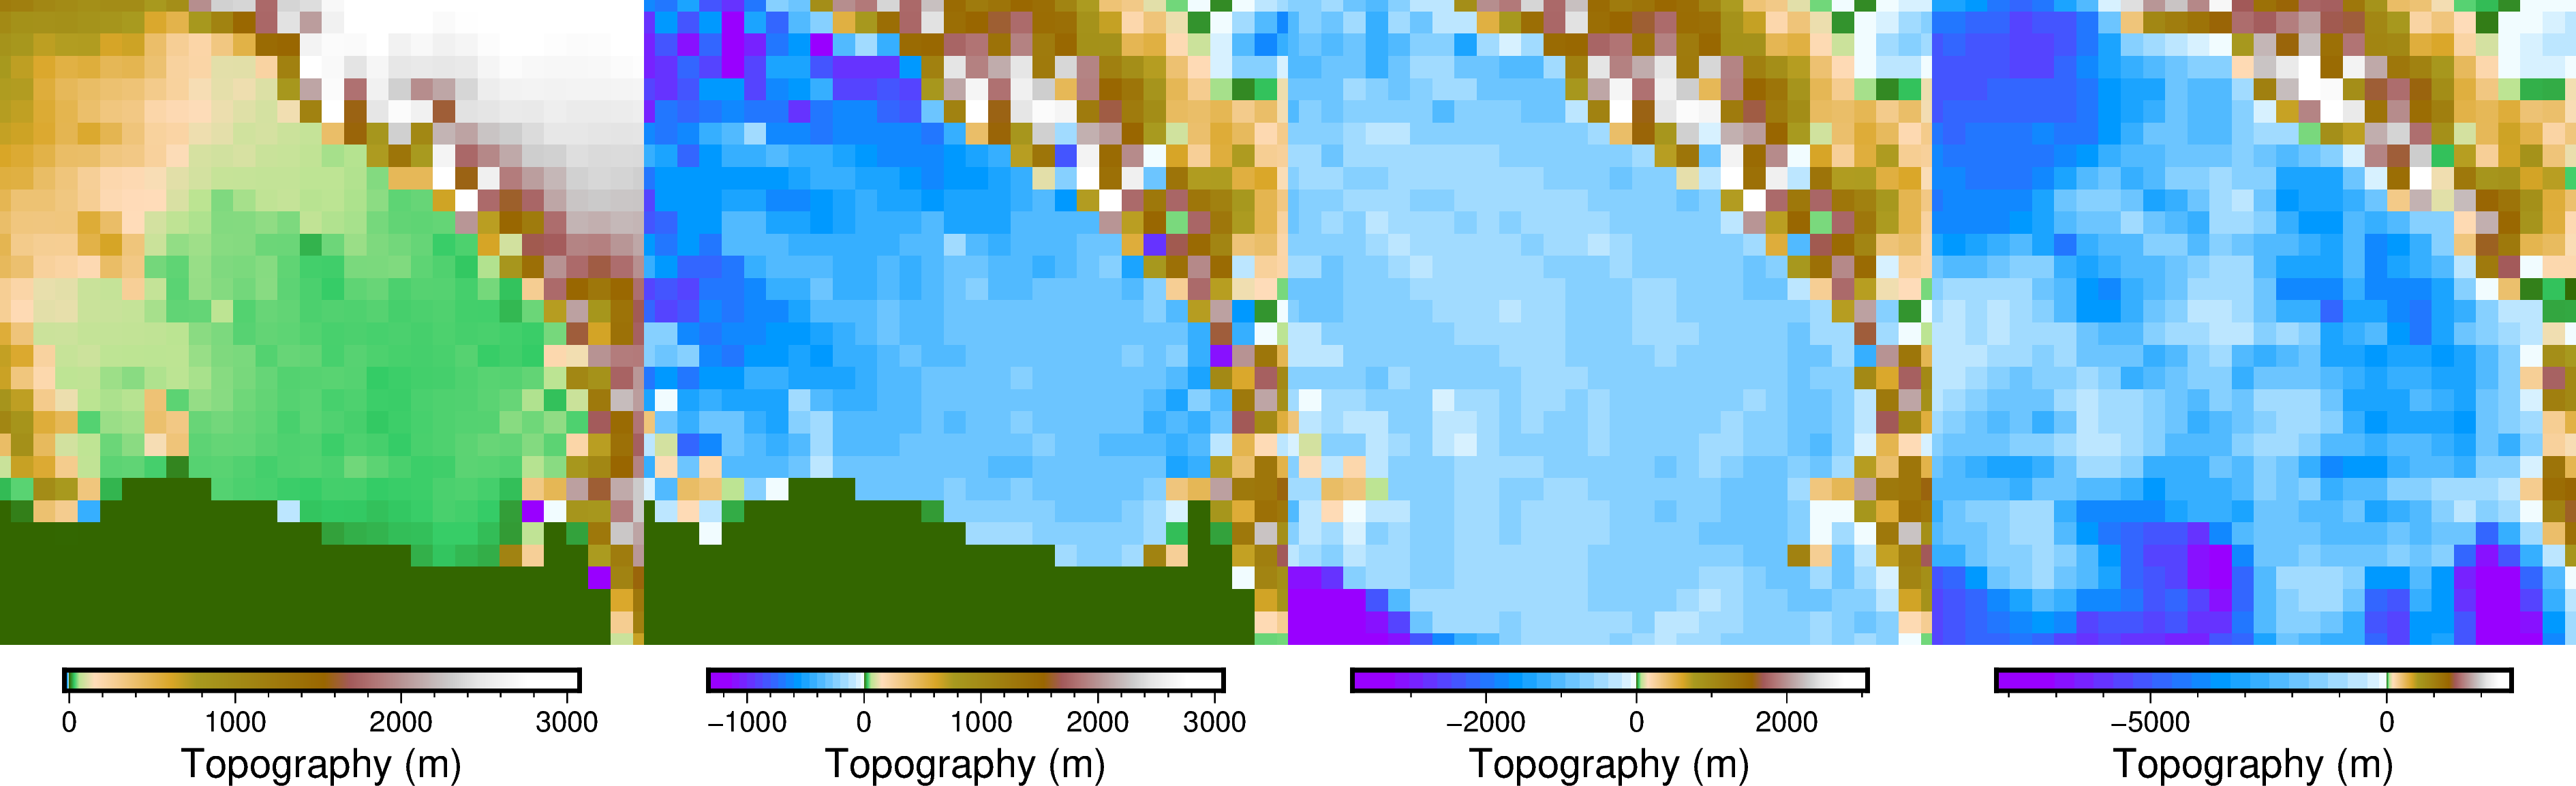

In [49]:
# df_regrid=pygmt.grdtrack(points=bed[['x','y']], grid=layers[reversed_layers_list[i-1]]['grid'], newcolname='z_regrid')
# layers[j]['df']['z_low']=layers[j]['df'].merge(df_regrid, how='left', on=['x','y']).z_regrid

fig = pygmt.Figure()

grid=surface.z
fig.grdimage(grid=grid, region=fig_reg, projection=fig_proj, cmap='globe')
fig.colorbar(frame='+lTopography (m)')

fig.shift_origin(xshift=fig_width/10)

grid=icebase.z
fig.grdimage(grid=grid, region=fig_reg, projection=fig_proj, cmap='globe')
fig.colorbar(frame='+lTopography (m)')

fig.shift_origin(xshift=fig_width/10)

grid=bed.z
fig.grdimage(grid=grid, region=fig_reg, projection=fig_proj, cmap='globe')
fig.colorbar(frame='+lTopography (m)')

fig.shift_origin(xshift=fig_width/10)

grid=basement.z
fig.grdimage(grid=grid, region=fig_reg, projection=fig_proj, cmap='globe')
fig.colorbar(frame='+lTopography (m)')

fig.show()

In [50]:
surface['density']=surface.z.copy()
surface.density.values[:] = 920 #890 to 917 from Muto et al. 2013

icebase['density']=icebase.z.copy()
icebase.density.values[:] = 1030 

bed['density']=bed.z.copy()
bed.density.values[:] = 2600 

basement['density']=basement.z.copy()
basement.density.values[:] = 2800 

ice_prisms=hm.prism_layer(
    coordinates=(list(surface.x), list(surface.y)),   
    surface=surface.z, 
    reference=icebase.z,
    properties={'density':surface.density})

water_prisms=hm.prism_layer(
    coordinates=(list(icebase.x), list(icebase.y)),   
    surface=icebase.z, 
    reference=bed.z,
    properties={'density':icebase.density})


# resample lower grid to be same spacing as bed
# df_bed=bed.to_dataframe().reset_index()
# df_regrid=pygmt.grdtrack(points=df_bed[['x','y']], grid=basement.z, newcolname='z_regrid')
# df_bed['z_low']=df_bed.merge(df_regrid, how='left', on=['x','y']).z_regrid
# bed_zlow=pygmt.xyz2grd(df_bed[['x','y','z_low']], region=inv_reg, spacing=20e3)
# sed_prisms=hm.prism_layer(
#     coordinates=(list(bed.x), list(bed.y)),   
#     surface=bed.z, 
#     reference=bed_zlow,
#     properties={'density':bed.density})

sed_prisms=hm.prism_layer(
    coordinates=(list(bed.x), list(bed.y)),   
    surface=bed.z, 
    reference=basement.z,
    properties={'density':bed.density})

basement_prisms=hm.prism_layer(
    coordinates=(list(basement.x), list(basement.y)),   
    surface=basement.z, 
    reference=-50e3,
    properties={'density':basement.density})

df_grav['ice'] = ice_prisms.prism_layer.gravity(
     coordinates=(df_grav.x, df_grav.y, df_grav.z),
     field = 'g_z',)

df_grav['water'] = water_prisms.prism_layer.gravity(
     coordinates=(df_grav.x, df_grav.y, df_grav.z),
     field = 'g_z',)    

df_grav['sed'] = sed_prisms.prism_layer.gravity(
     coordinates=(df_grav.x, df_grav.y, df_grav.z),
     field = 'g_z',)    

df_grav['basement'] = basement_prisms.prism_layer.gravity(
     coordinates=(df_grav.x, df_grav.y, df_grav.z),
     field = 'g_z',)    

df_grav['total'] = df_grav.ice + df_grav.water + df_grav.sed + df_grav.basement
df_grav['misfit'] = df_grav.Gobs -df_grav.total 

df_grav.describe()

,x,y,Gobs,z,ice,water,sed,basement,total,misfit
count,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-8.000000e+04,-9.200000e+05,-19.352316,2016.322021,48.159062,23.063188,137.184625,5228.831766,5437.238641,-5456.590957
std,5.773503e+05,5.773503e+05,26.597717,1199.770874,44.141659,51.011128,152.069290,487.982819,447.094871,446.672732
min,-1.060000e+06,-1.900000e+06,-167.969986,539.168945,-0.091868,0.009446,0.472881,2727.269514,3038.555624,-6061.970774
25%,-5.800000e+05,-1.420000e+06,-34.635001,778.450882,0.979623,0.027524,9.140192,5034.504054,5357.178457,-5704.003026
50%,-8.000000e+04,-9.200000e+05,-21.325000,1906.190552,38.291151,0.086302,81.687923,5377.300512,5615.353377,-5634.437711
75%,4.200000e+05,-4.200000e+05,-5.937500,3124.483948,90.996552,16.714658,222.322652,5554.752613,5676.237939,-5381.248418
max,9.000000e+05,6.000000e+04,135.619995,4798.599609,148.989108,185.353481,787.074982,5991.553867,6024.083838,-3061.555624


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


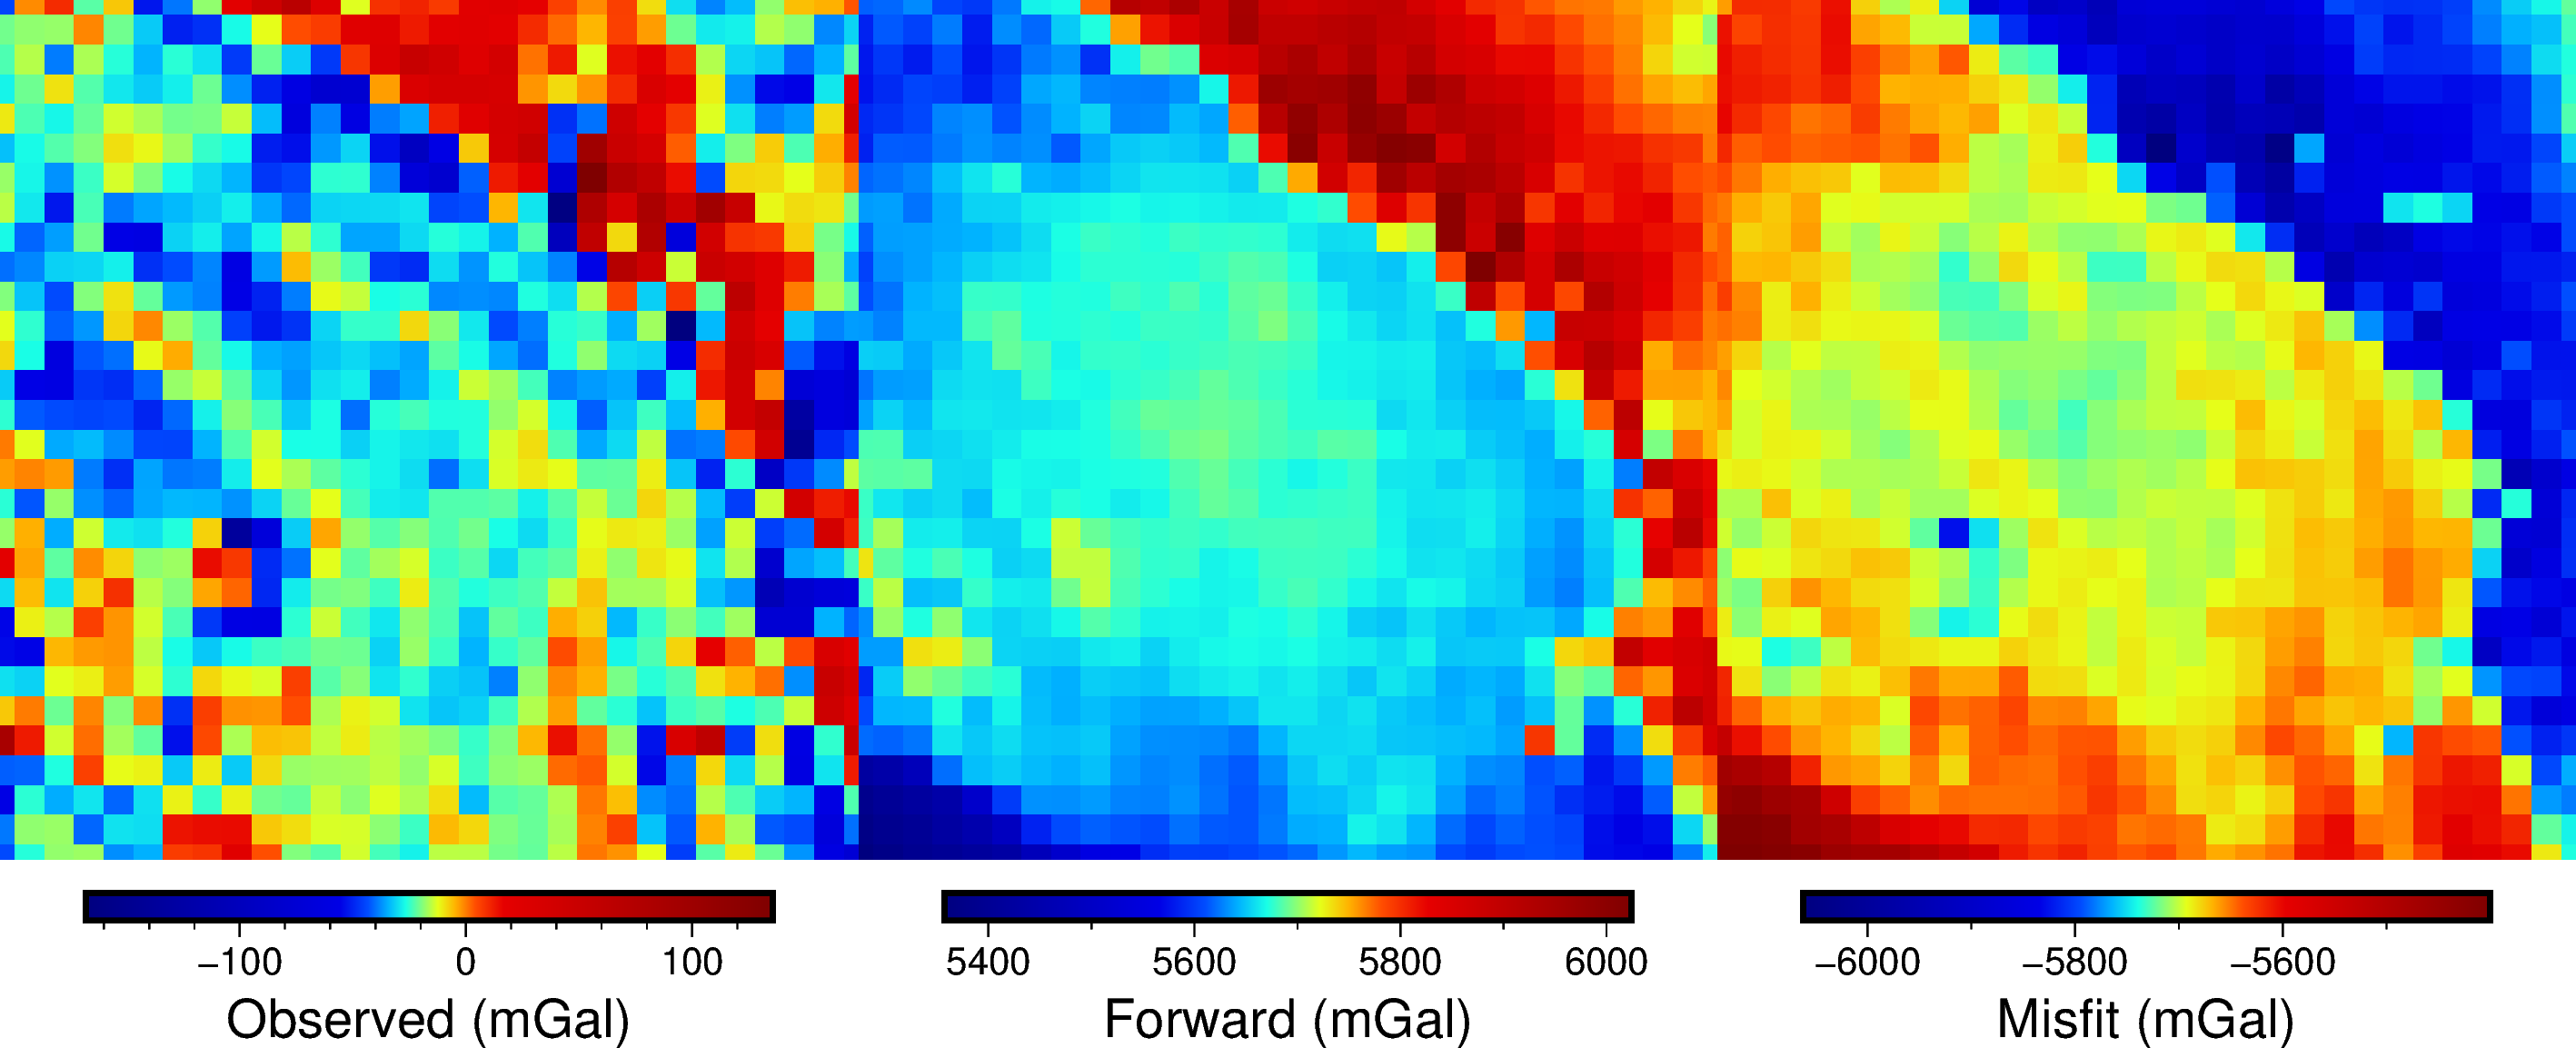

In [51]:
fig = pygmt.Figure()

data=df_grav[['x','y','Gobs']]
grid=pygmt.xyz2grd(data=data, region=inv_reg, spacing=40e3, projection=inv_proj)
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(grid=grid, region=fig_reg, projection=fig_proj, cmap=True)
fig.colorbar(frame='+lObserved (mGal)')

fig.shift_origin(xshift=inv_width/10)

data=df_grav[['x','y','total']]
grid=pygmt.xyz2grd(data=data, region=inv_reg, spacing=40e3, projection=inv_proj)
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(grid=grid, region=fig_reg, projection=fig_proj, cmap=True)
fig.colorbar(frame='+lForward (mGal)')

fig.shift_origin(xshift=inv_width/10)

data=df_grav[['x','y','misfit']]
grid=pygmt.xyz2grd(data=data, region=inv_reg, spacing=40e3, projection=inv_proj)
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(grid=grid, region=fig_reg, projection=fig_proj, cmap=True)
fig.colorbar(frame='+lMisfit (mGal)')

fig.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


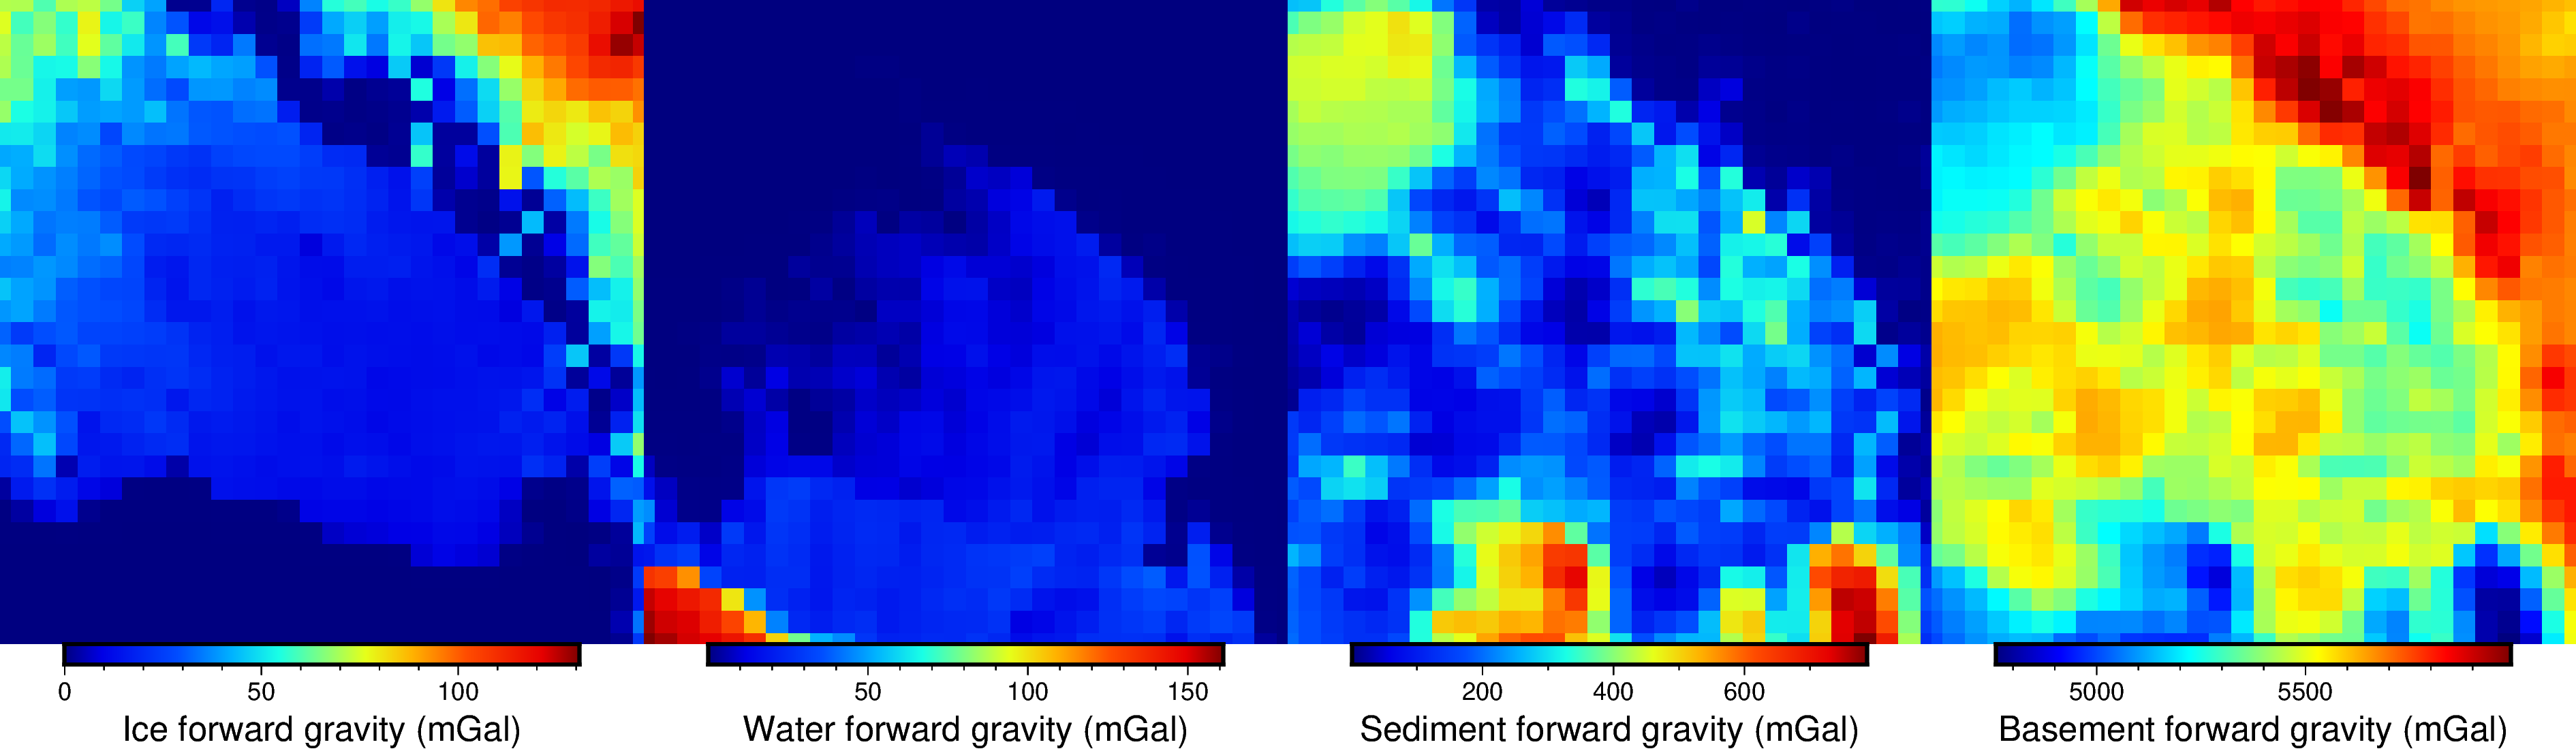

In [52]:
fig = pygmt.Figure()

data=pygmt.xyz2grd(data=df_grav[['x','y','ice']], region=inv_reg, spacing=40e3, projection=inv_proj)
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
fig.grdimage(
    data,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"Ice forward gravity (mGal)"')

fig.shift_origin(xshift=fig_width/10)

data=pygmt.xyz2grd(data=df_grav[['x','y','water']], region=inv_reg, spacing=40e3, projection=inv_proj)
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
fig.grdimage(
    data,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"Water forward gravity (mGal)"')

fig.shift_origin(xshift=fig_width/10)

data=pygmt.xyz2grd(data=df_grav[['x','y','sed']], region=inv_reg, spacing=40e3, projection=inv_proj)
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
# pygmt.makecpt(cmap="jet", series=[-200, 800], background=True, continuous=True)
fig.grdimage(
    data,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"Sediment forward gravity (mGal)"')

fig.shift_origin(xshift=fig_width/10)

data=pygmt.xyz2grd(data=df_grav[['x','y','basement']], region=fig_reg, spacing=40e3, projection=fig_proj)
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# pygmt.makecpt(cmap="jet", series=[4800, 6000], background=True, continuous=True)
fig.grdimage(
    data,
    cmap='jet',
    projection=fig_proj, 
    region=fig_reg,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"Basement forward gravity (mGal)"')

# # plot later figure extents (without=fig buffer)
# fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
#             y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
#             pen = '1p,black')

fig.show()